<>:48: SyntaxWarning: invalid escape sequence '\.'
<>:51: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\.'
<>:51: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1882079173.py:48: SyntaxWarning: invalid escape sequence '\.'
  line = re.sub('[^a-zA-Z0-9 \.]', ' ', line)
/tmp/ipython-input-1882079173.py:51: SyntaxWarning: invalid escape sequence '\s'
  line = re.sub('\s+', ' ', line).strip()


Device: cuda


===== Processing category1 from /content/shakespeare.txt =====
Vocab size: 11459
10 most frequent words: [('.', 41158), ('the', 6287), ('and', 5690), ('i', 5111), ('to', 4934), ('of', 3760), ('you', 3211), ('my', 3120), ('a', 3018), ('that', 2664)]
10 least frequent words (sample): ['relieved', 'humanely', 'afflicts', 'inventory', 'particularise', 'rakes', 'commonalty', 'conscienced', 'altitude', 'covetous']
Number of pairs: 249683
MLPTextGenerator(
  (embed): Embedding(11459, 64)
  (net): Sequential(
    (0): Linear(in_features=320, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=11459, bias=True)
  )
)
Epoch 1/120 | train_loss=5.7066 val_loss=5.4741 val_acc=0.1921
Epoch 2/120 | train_loss=5.1065 val_loss=5.4010 val_acc=0.1993
Epoch 3/120 | train_loss=4.7359 val_loss=5.4786 val_acc=0.2027
Epoch 4/120 | train_loss=4.3748 val_loss=5.7171 val_acc=0.2

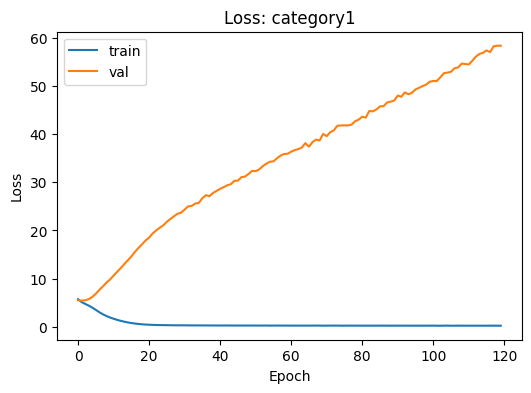

Example generations (temperature 0.5,1.0,2.0):
seed='the king' temp=0.5 -> the king of heaven . to let him deserved t . and
seed='the king' temp=1.0 -> the king of heaven . sword you have pray him that after
seed='the king' temp=2.0 -> the king of heaven . sword you have pray him that after
seed='to be or' temp=0.5 -> to be or of the house of the montagues . . sampson .
seed='to be or' temp=1.0 -> to be or of the house of the montagues . . sampson .
seed='to be or' temp=2.0 -> to be or of the house of the montagues . . sampson .
seed='function def' temp=0.5 -> function def . where to my heel shall from him . with
seed='function def' temp=1.0 -> function def . where to my heel shall from him . with
seed='function def' temp=2.0 -> function def . where to be and foot . richard what thou


===== Processing category2 from /content/python_code.txt =====
Upload the file to Colab at /content/python_code.txt
Running t-SNE (may take time)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


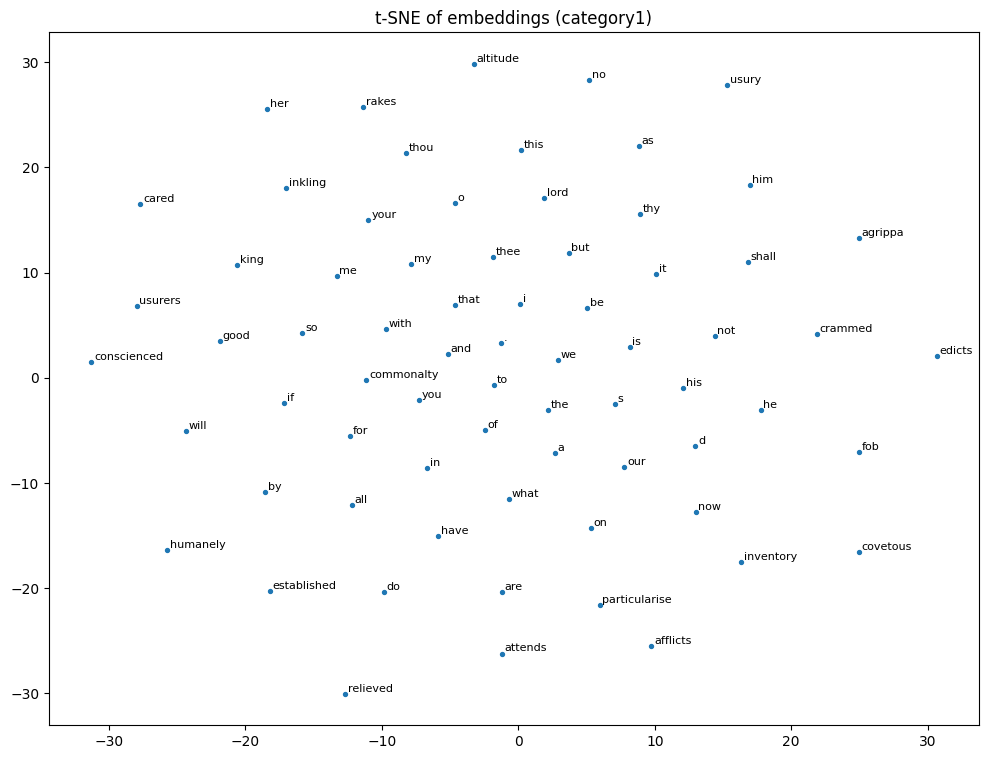

All done. Models and vocabs saved as model_category*.pth and vocab_category*.json


In [ ]:
# Colab-ready: Next-Word Prediction MLP (PyTorch)
# Save this notebook and run cell by cell.
# Required libraries: torch, sklearn, matplotlib, tqdm, sentencepiece (optional)
# If missing, install via pip.

!pip install torch torchvision torchaudio --quiet
!pip install matplotlib tqdm scikit-learn --quiet

# ---- Imports ----
import os, re, math, random, json, time
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---- User parameters ----
DATAFILES = {
    "category1": "/content/shakespeare.txt",   # upload this file in Colab
    "category2": "/content/python_code.txt"    # upload this file in Colab
}

# choose embedding dim 32 or 64
EMBED_DIM = 64
CONTEXT_LEN = 5   # number of previous words used to predict the next
HIDDEN_UNITS = 1024
HIDDEN_LAYERS = 2  # 1 or 2
ACTIVATION = 'relu'  # 'relu' or 'tanh'
BATCH_SIZE = 256
LR = 1e-3
EPOCHS = 120  # adjust (500-1000 can be used if you have time)
VAL_SPLIT = 0.1
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ---- Preprocessing utility functions ----
def preprocess_natural_line(line):
    # remove characters except alnum, space, and full-stop; preserve newline externally
    line = re.sub('[^a-zA-Z0-9 \.]', ' ', line)
    line = line.lower()
    # replace multiple spaces with single space
    line = re.sub('\s+', ' ', line).strip()
    return line

def preprocess_code_line(line):
    # For code: preserve most characters except control characters; but we'll remove leading/trailing spaces
    # We'll keep the line as is but replace tabs with spaces and collapse multiple spaces
    line = line.rstrip('\n')
    line = line.replace('\t', ' ')
    line = re.sub(' +', ' ', line).strip()
    return line

def read_and_preprocess(path, mode='natural'):
    lines = []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for raw in f:
            if mode == 'natural':
                line = preprocess_natural_line(raw)
                if line == '':
                    # keep an explicit sentence-break marker if there's a blank paragraph
                    lines.append('.')
                else:
                    # split on full-stop to form sentences
                    parts = [p.strip() for p in line.split('.') if p.strip()!='']
                    # re-add the full-stop as sentence terminator token '.' (kept as a separate word later)
                    for p in parts:
                        lines.append(p + ' .')
            else:
                # code mode: treat each newline as statement; keep punctuation
                line = preprocess_code_line(raw)
                if line == '':
                    continue
                # here keep newline as a separator token if you want:
                lines.append(line + ' NEWLINE')
    text = ' '.join(lines)
    return text

# ---- Vocabulary construction ----
def build_vocab(text, min_freq=1, max_vocab=None):
    # text is a string of space-separated tokens
    tokens = text.split()
    counter = Counter(tokens)
    if min_freq > 1:
        tokens_kept = [w for w,c in counter.items() if c>=min_freq]
    else:
        tokens_kept = list(counter.keys())
    # optional truncate by most common
    if max_vocab is not None:
        tokens_kept = [w for w,c in counter.most_common(max_vocab)]
    # special tokens
    stoi = {'<PAD>':0, '<UNK>':1}
    idx = len(stoi)
    for w in sorted(tokens_kept):
        if w in stoi: continue
        stoi[w] = idx
        idx += 1
    itos = {i:w for w,i in stoi.items()}
    return stoi, itos, counter

# ---- Create training pairs ----
def create_context_target_pairs(text, stoi, context_len):
    tokens = text.split()
    idxs = [stoi.get(w, stoi['<UNK>']) for w in tokens]
    X, Y = [], []
    for i in range(len(idxs)-context_len):
        context = idxs[i:i+context_len]
        target = idxs[i+context_len]
        X.append(context)
        Y.append(target)
    X = np.array(X, dtype=np.int64)
    Y = np.array(Y, dtype=np.int64)
    return X, Y

# ---- Dataset class ----
class ContextDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).long()
        self.Y = torch.from_numpy(Y).long()
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# ---- Model: Embedding + Flatten + MLP ----
class MLPTextGenerator(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, context_len=5, hidden_units=1024, hidden_layers=2, activation='relu'):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        in_dim = embed_dim * context_len
        layers = []
        for i in range(hidden_layers):
            layers.append(nn.Linear(in_dim if i==0 else hidden_units, hidden_units))
            if activation == 'relu':
                layers.append(nn.ReLU())
            else:
                layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_units, vocab_size))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        # x: (batch, context_len)
        emb = self.embed(x)  # (batch, context_len, embed_dim)
        flat = emb.view(emb.shape[0], -1)
        logits = self.net(flat)
        return logits

# ---- Training utilities ----
def train_model(model, train_loader, val_loader, epochs=50, lr=1e-3, device=device, print_every=1):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    best_val = float('inf')
    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item() * xb.size(0)
        avg_train = total_loss / len(train_loader.dataset)
        train_losses.append(avg_train)

        # validation
        model.eval()
        total_val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                total_val_loss += loss.item() * xb.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == yb).sum().item()
        avg_val = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val)
        val_acc = correct / len(val_loader.dataset)

        if epoch % print_every == 0:
            print(f"Epoch {epoch}/{epochs} | train_loss={avg_train:.4f} val_loss={avg_val:.4f} val_acc={val_acc:.4f}")
        # save best
        if avg_val < best_val:
            best_val = avg_val
            torch.save({'model_state': model.state_dict()}, 'best_model.pt')
    return train_losses, val_losses

# ---- Sampling from model with temperature ----
def sample_next_word(model, context_tokens, stoi, itos, temperature=1.0, top_k=None):
    model.eval()
    idxs = [stoi.get(w, stoi['<UNK>']) for w in context_tokens]
    xb = torch.tensor([idxs], dtype=torch.long).to(device)
    with torch.no_grad():
        logits = model(xb).squeeze(0).cpu().numpy()
    logits = logits / max(1e-9, temperature)
    # numeric stability
    exp = np.exp(logits - np.max(logits))
    probs = exp / exp.sum()
    if top_k is not None:
        top_k_idx = np.argsort(probs)[-top_k:]
        mask = np.ones_like(probs, dtype=bool)
        mask[:] = False
        mask[top_k_idx] = True
        filtered = np.where(mask, probs, 0)
        if filtered.sum() == 0:
            filtered = probs
        probs = filtered / filtered.sum()
    choice = np.random.choice(len(probs), p=probs)
    return itos[choice]

def generate_text(model, seed_text, k, stoi, itos, context_len=5, temperature=1.0):
    words = seed_text.lower().split()
    for _ in range(k):
        ctx = words[-context_len:]
        if len(ctx) < context_len:
            ctx = ['<PAD>']*(context_len-len(ctx)) + ctx
        nxt = sample_next_word(model, ctx, stoi, itos, temperature=temperature)
        words.append(nxt)
    return ' '.join(words)

# ---- Run preprocessing, build vocab, dataset, train for both categories ----
results = {}
for cat, path in DATAFILES.items():
    print("\n\n===== Processing", cat, "from", path, "=====")
    if not os.path.exists(path):
        print("Upload the file to Colab at", path)
        continue
    mode = 'natural' if cat == 'category1' else 'code'
    text = read_and_preprocess(path, mode=('natural' if cat=='category1' else 'code'))
    # build vocab: you can set min_freq or max_vocab here
    stoi, itos, counter = build_vocab(text, min_freq=1, max_vocab=None)
    vocab_size = len(stoi)
    print("Vocab size:", vocab_size)
    # top 10 frequent and least frequent
    most10 = counter.most_common(10)
    least10 = [w for w,c in counter.items() if c==1][:10]
    print("10 most frequent words:", most10)
    print("10 least frequent words (sample):", least10)

    # create dataset
    X, Y = create_context_target_pairs(text, stoi, CONTEXT_LEN)
    print("Number of pairs:", X.shape[0])
    # create dataloaders
    dataset = ContextDataset(X, Y)
    val_count = int(len(dataset)*VAL_SPLIT)
    train_count = len(dataset)-val_count
    train_ds, val_ds = random_split(dataset, [train_count, val_count])
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # build model
    model = MLPTextGenerator(vocab_size=vocab_size, embed_dim=EMBED_DIM, context_len=CONTEXT_LEN,
                             hidden_units=HIDDEN_UNITS, hidden_layers=HIDDEN_LAYERS, activation=ACTIVATION).to(device)
    print(model)
    # train
    train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR)
    # save artefacts
    torch.save({'model_state': model.state_dict(),
                'stoi': stoi, 'itos': itos,
                'train_losses': train_losses, 'val_losses': val_losses}, f'model_{cat}.pth')
    results[cat] = {'model': model, 'stoi': stoi, 'itos': itos, 'train_losses': train_losses, 'val_losses': val_losses, 'counter': counter}

    # plot losses
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss: {cat}')
    plt.legend()
    plt.show()

    # show some example predictions
    print("Example generations (temperature 0.5,1.0,2.0):")
    seeds = ["the king", "to be or", "function def"]
    for s in seeds:
        for temp in [0.5, 1.0, 2.0]:
            out = generate_text(model, s, k=10, stoi=stoi, itos=itos, context_len=CONTEXT_LEN, temperature=temp)
            print(f"seed='{s[:30]}' temp={temp} ->", out)
    # embedding matrix
    emb_weights = model.embed.weight.detach().cpu().numpy()
    results[cat]['embeddings'] = emb_weights

# ---- Embedding visualization (example for one category) ----
# pick category1 for t-SNE
cat = 'category1' if 'category1' in results else list(results.keys())[0]
emb = results[cat]['embeddings']
stoi = results[cat]['stoi']
itos = results[cat]['itos']
counter = results[cat]['counter']

# choose words to visualize: most frequent, some function words, some rare words
most_words = [w for w,_ in counter.most_common(200)]
selected = []
selected += most_words[:50]
# also add some rare words (sample)
rare = [w for w,c in counter.items() if c==1][:50]
selected += rare[:20]
selected = list(dict.fromkeys(selected))[:150]  # unique, up to 150

indices = [stoi.get(w, stoi['<UNK>']) for w in selected]
vecs = emb[indices]

print("Running t-SNE (may take time)...")
tsne = TSNE(n_components=2, perplexity=30, random_state=SEED, n_iter=1000)
Y = tsne.fit_transform(vecs)

plt.figure(figsize=(12,9))
plt.scatter(Y[:,0], Y[:,1], s=8)
for i, w in enumerate(selected):
    plt.text(Y[i,0]+0.2, Y[i,1]+0.2, w, fontsize=8)
plt.title(f"t-SNE of embeddings ({cat})")
plt.show()

# Save vocab and model mapping for Streamlit
for cat, v in results.items():
    with open(f'vocab_{cat}.json','w',encoding='utf-8') as f:
        json.dump(v['stoi'], f)

print("All done. Models and vocabs saved as model_category*.pth and vocab_category*.json")
